**Anomaly Detection** 

Abnormalities like fraud detection differ from the regular data in terms of patterns. An important characteristic of any anomaly dataset is class imbalance. To train a supervised model on such imbalanced dataset will not lead to promising results. The concept is that we train an unsupervised autoencoder on normal data, so all the feature generations that it will learn will be based on the characteristics of normal data and hence the reconstruction error will be low for non-fraud data.

After the training is done, take a fraud record and pass itinto the autoencoder network and calculate the reconstruction error. This will be high because none of the features that the model learnt can explain this fraud. 

So, we can identify whether a particular datapoint is fraud or not based on the error. All samples for which the reconstruction error is small are similar to normal data. Those samples for which the reconstruction error is high are the anomalies.

Similar thing can be applied to train cat and dog problem. Let’s say we train an autoencoder on cats, the only features it learns is about cats. After the training is done let us say we pass a dog to the autoencoder network, the construction looks like a cat because the network doesn’t know anything about the dog and the reconstruction error will be high.

#### Loading required libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from keras.layers import Input, Dense, Dropout
from keras.models import Model

import matplotlib.pyplot as plt
%matplotlib inline

#### Reading and Understanding the data

In [3]:
import os
os.chdir(r"/content/drive/MyDrive/autoencoders")

In [4]:
data = pd.read_csv("Fraud_data_amtstd.csv")

In [5]:
# dimensions
data.shape

(64456, 30)

In [6]:
# first few records of the data
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1.836500,-0.545419,-0.462979,0.537174,-0.426143,-0.100606,-0.584764,-0.103956,2.268429,-0.365185,0.122337,-2.117327,2.261481,1.287914,0.197872,0.495713,0.043528,0.317547,-0.662213,0.013151,0.085111,0.410736,0.137625,0.602906,-0.350260,0.464407,-0.070917,-0.030486,0.049882,0.0
1,-4.289880,-2.576061,-0.092256,1.976405,2.810033,-2.669128,-0.981883,-0.470310,-0.025692,0.099528,0.803329,-0.042235,0.047051,-1.413220,2.000006,-0.096278,1.752810,-0.252515,0.462189,-1.320905,-0.473240,-0.307295,-2.789549,0.578976,-0.837979,0.372843,0.353451,-1.662202,-0.347171,0.0
2,1.131318,0.139818,0.586921,1.069291,-0.334908,-0.204938,-0.135526,0.043821,-0.121117,0.182139,1.034059,0.846406,0.149111,0.385353,0.414530,0.657300,-0.925449,0.501254,-0.067021,-0.043168,-0.028126,-0.167062,-0.048054,-0.009912,0.417694,-0.479793,0.024360,0.023878,-0.208963,0.0
3,-0.866956,1.373947,1.948343,2.686750,-0.366790,0.568632,-0.278349,0.739536,-1.655955,0.708396,0.871947,0.586652,0.838078,0.391226,0.844220,0.703376,-0.365869,0.837992,1.036112,0.328626,0.022719,-0.070619,-0.080307,0.000816,0.092167,0.159131,0.157940,-0.014370,-0.253595,0.0
4,-0.842670,1.401843,0.927235,1.070402,0.843883,0.467333,0.366716,0.616739,-1.586963,0.000041,-0.409240,0.139799,0.319222,0.538952,-0.760940,1.572230,-1.475274,0.748143,-0.725295,-0.208826,0.036573,-0.182581,-0.226834,-1.029794,-0.118762,-0.228960,-0.024250,0.046547,-0.346230,0.0


In [7]:
data.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')

In [8]:
data.dtypes

V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class     float64
dtype: object

#### Data distribution w.r.t the target attribute

In [9]:
print("**Target Distribution***\n")
print(pd.value_counts(data['Class']))
print("\n\n")
print("***Target Distribution in Percentage***\n")
print(pd.value_counts(data['Class'])[0]/data['Class'].shape[0])
print(pd.value_counts(data['Class'])[1]/data['Class'].shape[0])

**Target Distribution***

0.0    64147
1.0      308
Name: Class, dtype: int64



***Target Distribution in Percentage***

0.9952060320218443
0.0047784535186794095


#### Let's visualize the target distribution using a barplot

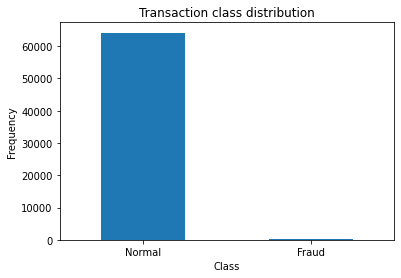

In [10]:
# Drawing a barplot
pd.value_counts(data['Class']).plot(kind = 'bar', rot=0)
# Giving titles and labels to the plot
plt.title("Transaction class distribution")
plt.xticks(range(2), ["Normal", "Fraud"])
plt.xlabel("Class")
plt.ylabel("Frequency");

O = Normal
1 = Fraud

#### Extracting numpy array from the DataFrame

In [11]:
data = data.values

#### Train test split

Splitting the data into train and test, such that train data has only non-fraud records and test data has both. 

In [12]:
data_nf = data[data[:,-1] == 0]
test_f  = data[data[:,-1] == 1]

train_nf, test_nf = train_test_split(data_nf, test_size=0.2, random_state=123)

In [13]:
print(data.shape)
print(train_nf.shape)
print(test_nf.shape)
print(test_f.shape)

(64456, 30)
(51317, 30)
(12830, 30)
(308, 30)


#### Look at the distribution w.r.t target attribute

In [14]:
print(np.unique(data[:,-1], return_counts=True))
print(np.unique(train_nf[:,-1], return_counts=True))
print(np.unique(test_nf[:,-1], return_counts=True))
print(np.unique(test_f[:,-1], return_counts=True))

(array([ 0.,  1., nan]), array([64147,   308,     1]))
(array([0.]), array([51317]))
(array([0.]), array([12830]))
(array([1.]), array([308]))


#### Extracting the independent features¶

In [15]:
X_train_nf = train_nf[:,:-1]
X_test_nf = test_nf[:,:-1]
X_test_f = test_f[:,:-1]

#### Building an Autoencoder

In [16]:
input_dim = X_train_nf.shape[1]
encoding_dim = 150
input_dim

29

In [17]:
# Input placeholder
input_att = Input(shape=(input_dim,))

input_dropout = Dropout(0.2)(input_att)
 
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_dropout)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(input_dim, activation='linear')(encoded)

#### Check the summary of the model

In [19]:
autoencoder = Model(input_att, decoded)

In [20]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dropout (Dropout)            (None, 29)                0         
_________________________________________________________________
dense (Dense)                (None, 150)               4500      
_________________________________________________________________
dense_1 (Dense)              (None, 29)                4379      
Total params: 8,879
Trainable params: 8,879
Non-trainable params: 0
_________________________________________________________________


#### Compile the model

In [21]:
autoencoder.compile(loss='mean_squared_error', optimizer='adam')

#### Fit the model

In [22]:
autoencoder.fit(X_train_nf, X_train_nf, epochs=100, shuffle=True, validation_split=0.2, verbose=1)

Epoch 1/100
1283/1283 [==============================] - 3s 2ms/step - loss: 0.2729 - val_loss: 0.0557
Epoch 2/100
1283/1283 [==============================] - 2s 2ms/step - loss: 0.1730 - val_loss: 0.0511
Epoch 3/100
1283/1283 [==============================] - 2s 2ms/step - loss: 0.1616 - val_loss: 0.0497
Epoch 4/100
1283/1283 [==============================] - 2s 2ms/step - loss: 0.1473 - val_loss: 0.0603
Epoch 5/100
1283/1283 [==============================] - 2s 2ms/step - loss: 0.1444 - val_loss: 0.0403
Epoch 6/100
1283/1283 [==============================] - 2s 2ms/step - loss: 0.1363 - val_loss: 0.0413
Epoch 7/100
1283/1283 [==============================] - 2s 2ms/step - loss: 0.1324 - val_loss: 0.0428
Epoch 8/100
1283/1283 [==============================] - 2s 2ms/step - loss: 0.1310 - val_loss: 0.0374
Epoch 9/100
1283/1283 [==============================] - 2s 2ms/step - loss: 0.1230 - val_loss: 0.0396
Epoch 10/100
1283/1283 [==============================] - 2s 2ms/step - l

#### Saving a Keras model

In [23]:
autoencoder.save('models/ae1')

INFO:tensorflow:Assets written to: models/ae1/assets


#### Loading the model back

In [24]:
from tensorflow import keras
autoencoder = keras.models.load_model('models/ae1')

#### Evaluate the loss on non-fraud train data

In [25]:
autoencoder.evaluate(X_train_nf, X_train_nf)

1604/1604 [==============================] - 2s 1ms/step - loss: 0.0379


0.037930332124233246

#### Evaluate the loss on non-fraud test data

In [26]:
autoencoder.evaluate(X_test_nf, X_test_nf)

401/401 [==============================] - 0s 1ms/step - loss: 0.0372


0.03717506304383278

#### Evaluate the loss on fraud test data

In [27]:
autoencoder.evaluate(X_test_f, X_test_f)

10/10 [==============================] - 0s 2ms/step - loss: 1.8185


1.8184670209884644

#### Function to calculate mse for each record

In [28]:
def mse_for_each_record(act, pred):
    error = act - pred
    squared_error = np.square(error)
    mean_squared_error = np.mean(squared_error, axis=1)
    return mean_squared_error

#### Making predictions on the non-fraud train data

In [29]:
pred_train_nf = autoencoder.predict(X_train_nf)
print(pred_train_nf.shape)

mse_train_nf = mse_for_each_record(X_train_nf, pred_train_nf)
print(mse_train_nf.shape)

(51317, 29)
(51317,)


#### Making predictions on the non-fraud test data

In [30]:
pred_test_nf = autoencoder.predict(X_test_nf)
print(pred_test_nf.shape)

mse_test_nf = mse_for_each_record(X_test_nf, pred_test_nf)
print(mse_test_nf.shape)

(12830, 29)
(12830,)


#### Making predictions on the fraud test data

In [31]:
pred_test_f = autoencoder.predict(X_test_f)
print(pred_test_f.shape)

mse_test_f = mse_for_each_record(X_test_f, pred_test_f)
print(mse_test_f.shape)

(308, 29)
(308,)


#### Explore and identify right cut-off

{'boxes': [<matplotlib.lines.Line2D at 0x7f1c2bbc0e10>],
 'caps': [<matplotlib.lines.Line2D at 0x7f1c2bc0ff90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f1c2bcad9d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f1c2bcadc50>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f1c2bbc0150>,
  <matplotlib.lines.Line2D at 0x7f1c2bc0fbd0>]}

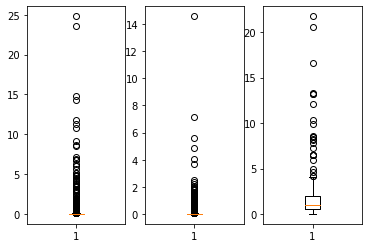

In [32]:
# mse box plots of non-fraud train, non-fraud test and fraud test data
plt.subplot(1, 3, 1)
plt.boxplot(mse_train_nf)

plt.subplot(1, 3, 2)
plt.boxplot(mse_test_nf)

plt.subplot(1, 3, 3)
plt.boxplot(mse_test_f)

In [33]:
# Summary statistics on mse of non-fraud train, non-fraud test and fraud test data
print("-------mse_train_nf-------")
print(pd.Series(mse_train_nf).describe())
print("\n-------mse_test_NF-------")
print(pd.Series(mse_test_nf).describe())
print("\n-------mse_test_f-------")
print(pd.Series(mse_test_f).describe())

-------mse_train_nf-------
count    51317.000000
mean         0.037930
std          0.250271
min          0.001510
25%          0.010196
50%          0.016795
75%          0.027703
max         24.815616
dtype: float64

-------mse_test_NF-------
count    12830.000000
mean         0.037175
std          0.189868
min          0.001692
25%          0.010263
50%          0.016839
75%          0.027728
max         14.581040
dtype: float64

-------mse_test_f-------
count    308.000000
mean       1.818467
std        2.797170
min        0.008440
25%        0.549259
50%        1.004228
75%        1.990687
max       21.750461
dtype: float64


#### Define cut-off error/MSE

In [34]:
cut_off = np.round(np.percentile(mse_train_nf,99),2)
print("Cut-off = {}".format(cut_off))

Cut-off = 0.35


#### % of correctly predicted non-fraud train, non-fraud test and fraud test records

In [35]:
print("Non-fraud train records = {}%".format(np.round(np.sum(mse_train_nf <= cut_off)/train_nf.shape[0],2)*100))
print("Non-fraud test records  = {}%".format(np.round(np.sum(mse_test_nf <= cut_off)/test_nf.shape[0],2)*100))
print("Fraud test records      = {}%".format(np.round(np.sum(mse_test_f > cut_off)/test_f.shape[0],2)*100))

Non-fraud train records = 99.0%
Non-fraud test records  = 99.0%
Fraud test records      = 82.0%
